In [1]:
%env CUDA_VISIBLE_DEVICES=

env: CUDA_VISIBLE_DEVICES=


In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
n_gpus = 1

In [4]:
import tensorflow as tf
from tensorflow.contrib import slim
print(tf.__version__)

1.0.0


In [5]:
with open("../data/eng_vocabs.txt", encoding="utf-8") as f:
    dictionary = {}
    for i, line in enumerate(f):
        token = line.strip("\n")
        dictionary[token] = int(i) + 4
        
with open("../data/jpn_vocabs.txt", encoding="utf-8") as f:
    inv_dictionary = {}
    for i, line in enumerate(f):
        inv_dictionary[i + 4] = line.strip("\n")
    inv_dictionary[0] = "<PAD>"
    inv_dictionary[1] = "<GO>"
    inv_dictionary[2] = "<UNK>"
    inv_dictionary[3] = "<EOS>"

In [6]:
emb_size = 512
n_hidden = 512
en_vocab_size = 131 + 4
jp_vocab_size = 3202 + 4
n_layers = 4

In [7]:
def init_embedding(X, Y, reuse=False):
    with tf.variable_scope("embedding", reuse=reuse), tf.device("/cpu:0"):
        en_emb = tf.get_variable("en_emb", 
                                [en_vocab_size, emb_size], 
                                dtype=tf.float32,
                                initializer=tf.truncated_normal_initializer(stddev=1e-4))

        jp_emb = tf.get_variable("jp_emb", 
                                [jp_vocab_size, emb_size], 
                                dtype=tf.float32,
                                initializer=tf.truncated_normal_initializer(stddev=1e-4))

        P_in = tf.get_variable("P_in", 
                            [401, emb_size], 
                            dtype=tf.float32,
                            initializer=tf.truncated_normal_initializer(stddev=1e-4))
        P_out = tf.get_variable("P_out", 
                            [402, emb_size], 
                            dtype=tf.float32,
                            initializer=tf.truncated_normal_initializer(stddev=1e-4))

        X_emb = tf.nn.embedding_lookup(en_emb, X) + P_in[:tf.shape(X)[1], :]
        Y_emb = tf.nn.embedding_lookup(jp_emb, Y) + P_out[:tf.shape(Y)[1], :]
        return X_emb, Y_emb

In [8]:
def encoder_block(inp, n_hidden, filter_size):
    inp = tf.expand_dims(inp, 2)
    inp = tf.pad(inp, [[0, 0], [(filter_size[0]-1)//2, (filter_size[0]-1)//2], [0, 0], [0, 0]])
    conv = slim.convolution(inp, n_hidden, filter_size, data_format="NHWC", padding="VALID", activation_fn=None)
    conv = tf.squeeze(conv, 2)
    return conv

def decoder_block(inp, n_hidden, filter_size):
    inp = tf.expand_dims(inp, 2)
    inp = tf.pad(inp, [[0, 0], [filter_size[0]-1, 0], [0, 0], [0, 0]])
    conv = slim.convolution(inp, n_hidden, filter_size, data_format="NHWC", padding="VALID", activation_fn=None)
    conv = tf.squeeze(conv, 2)
    return conv

In [9]:
def glu(x):
    return tf.multiply(x[:, :, :tf.shape(x)[2]//2], tf.sigmoid(x[:, :, tf.shape(x)[2]//2:]))

In [10]:
def layer(inp, conv_block, kernel_width, n_hidden, residual=None):
    z = conv_block(inp, n_hidden, (kernel_width, 1))
    return glu(z) + (residual if residual is not None else 0)

In [14]:
def encoder(inp, n_layers, device):
    with tf.variable_scope("encoder", reuse=device > 0), tf.device("/gpu:%d" % device):
        e = inp
        for i in range(n_layers):
            z = layer(inp, encoder_block, 3, n_hidden * 2, inp)
            inp = z
        return z, z + e

In [15]:
def decoder(inp, zu, ze, n_layers, device):
    with tf.variable_scope("decoder", reuse=device > 0), tf.device("/gpu:%d" % device):
        g = inp
        for i in range(n_layers):
            attn_res = h = layer(inp, decoder_block, 3, n_hidden * 2, residual=tf.zeros_like(inp))
            d = slim.linear(h, n_hidden) + g
            dz = tf.matmul(d, tf.transpose(zu, [0, 2, 1]))
            a = tf.nn.softmax(dz)
            c = tf.matmul(a, ze)
            h = slim.linear(attn_res + c, n_hidden)
            inp = h
        return h

In [17]:
tf.reset_default_graph()

X = tf.placeholder(dtype=tf.int32, shape=(None, None))
Y = tf.placeholder(dtype=tf.int32, shape=(None, None))
n_layers = 4
en_emb, jp_emb = init_embedding(X, Y, reuse=False)
zu, ze = encoder(en_emb, n_layers, device=0)

zu_placeholder = tf.placeholder(zu.dtype, zu.get_shape())
ze_placeholder = tf.placeholder(ze.dtype, ze.get_shape())
hg = decoder(jp_emb, zu_placeholder, ze_placeholder, n_layers, device=0)

with tf.variable_scope("logits"):
    logits = slim.fully_connected(hg, jp_vocab_size)
    logits = logits[:, :-1]
    p = tf.nn.softmax(logits)
    k = tf.placeholder(dtype=tf.int32)
    topk_logprobs, topk_ids = tf.nn.top_k(tf.log(p), k)

In [18]:
def encode(sess, enc_inputs):
    input_feed = {X: enc_inputs}
    outputs = [zu, ze]
    return sess.run(outputs, input_feed)

def decode_topk(sess, zu_inputs, ze_inputs, dec_inputs, beam_size):
    input_feed = {zu_placeholder: zu_inputs, 
                  ze_placeholder: ze_inputs,
                  k: beam_size * 2,
                  Y: dec_inputs}
    outputs = [topk_logprobs, topk_ids]
    return sess.run(outputs, input_feed)

In [19]:
class Hypothesis(object):
    def __init__(self, log_prob, seq):
        self.log_prob = log_prob
        self.seq = seq
    
    @property
    def step(self):
        return len(self.seq) - 1


def beam_search(sess, zu_inputs, ze_inputs, batch_size, beam_size, num_ans, max_len, normalize_by_len=1.):        
    assert 0 <= normalize_by_len <= 1
    # decode
    dec_inputs = np.ones((batch_size, 2), dtype=np.int32)
    answers = [[] for i in range(batch_size)]
    H = [[] for i in range(batch_size)]
    
    tkl, tkid = decode_topk(sess, zu_inputs, ze_inputs, dec_inputs, beam_size)  # step, batch_size, k

    for i in range(batch_size):
        for j, log_prob in enumerate(tkl[i, 0]):  # only need to consider step 0th
            if tkid[i, 0, j] != 3:
                h = Hypothesis(log_prob, [1, tkid[i, 0, j]])
                H[i].append(h)
        H[i].sort(key=lambda h: h.log_prob)

    done = [False] * batch_size
    while not all(done):            
        tkl_beam = []
        tkid_beam = []
        dec_inputs_beam = []
        steps_beam = []
        for i in range(beam_size):
            steps = [1] * batch_size
            prev_log_probs = np.zeros(batch_size, dtype=np.float32)
            dec_inputs = np.ones((batch_size, max_len), dtype=np.int32)
            for j, h in enumerate(H):
                while h:
                    hi = h.pop()
                    lp, step, candidate_seq = hi.log_prob, hi.step, hi.seq
                    if candidate_seq[-1] != 3:
                        dec_inputs[j, :len(candidate_seq)] = candidate_seq
                        steps[j] = step
                        prev_log_probs[j] = lp
                        break
                    else:
                        answers[j].append((lp, candidate_seq))
            max_step = max(steps)
            dec_inputs = dec_inputs[:, :max_step + 2]
            tkl, tkid = decode_topk(sess, zu_inputs, ze_inputs, dec_inputs, beam_size)  # step, batch_size, k
            tkl_beam.append(tkl + prev_log_probs[:, None, None])
            tkid_beam.append(tkid)
            dec_inputs_beam.append(dec_inputs.copy())
            steps_beam.append(steps)
            
        for i in range(beam_size):
            tkl = tkl_beam[i]
            tkid = tkid_beam[i]
            dec_inputs = dec_inputs_beam[i]
            steps = steps_beam[i]
            for j in range(batch_size):
                step = steps[j]
                for k in range(tkid.shape[2]):
                    extended_seq = np.hstack((dec_inputs[j, :step+1], [tkid[j, step, k]]))
                    log_prob = tkl[j, step, k]
                    if len(extended_seq) <= max_len and log_prob > -10:
                        h = Hypothesis(log_prob, extended_seq)
                        H[j].append(h)

                H[j].sort(key=lambda h: h.log_prob / (h.step**normalize_by_len))
        
        for i in range(batch_size):
            done[i] = (len(answers[i]) >= num_ans) or (not H[i]) or (len(H[i]) > 1000)
    return answers

In [28]:
import json


def format_log(c, ans):
    for log_prob, kw in ans:
        out += "\t[%.4f] %s\n" % (log_prob, to_text(kw, inv_dictionary))
    return out

def to_text(data, inv_dictionary, ignore_special_char=True, reverse=False):
    if ignore_special_char:
        data = [x for x in data if x > 3]
    if reverse:
        return "".join([inv_dictionary[i] for i in data[::-1]])
    return "".join([inv_dictionary[i] for i in data])

In [29]:
saver = tf.train.Saver()

config = tf.ConfigProto(allow_soft_placement=True)
isess = tf.InteractiveSession(config=config)
isess.run(tf.global_variables_initializer())
saver.restore(isess, "../checkpoints/tatoeba/model.ckpt")

In [30]:
def translate(text):
    max_len = min(400, 1 + np.max([len(t) for t in text]))
    T = np.zeros((len(text), 400), dtype=np.int32)
    for i, t in enumerate(text):
        for j, x in enumerate(t):
            T[i, j] = dictionary.get(x, 2)
        T[i, j + 1] = 3
    zu_inputs, ze_inputs = encode(isess, T)
    answers = beam_search(isess, zu_inputs, ze_inputs, batch_size=T.shape[0], beam_size=4, num_ans=10, max_len=402, normalize_by_len=0.1)
    for i, ans in enumerate(answers):
        ans.sort(key=lambda x: x[0], reverse=True)
        print(format_log(ans))
        print(len(ans))

In [ ]:
translate("How are you?")

In [40]:
# Visualize Attentions
def compute_attentions(isess, X_in, Y_in):
    zu_in, ze_in = encode(isess, X_in)
    input_feed = {zu_placeholder: zu_in, 
                  ze_placeholder: ze_in,
                  Y: Y_in}
    return isess.run(A, input_feed)

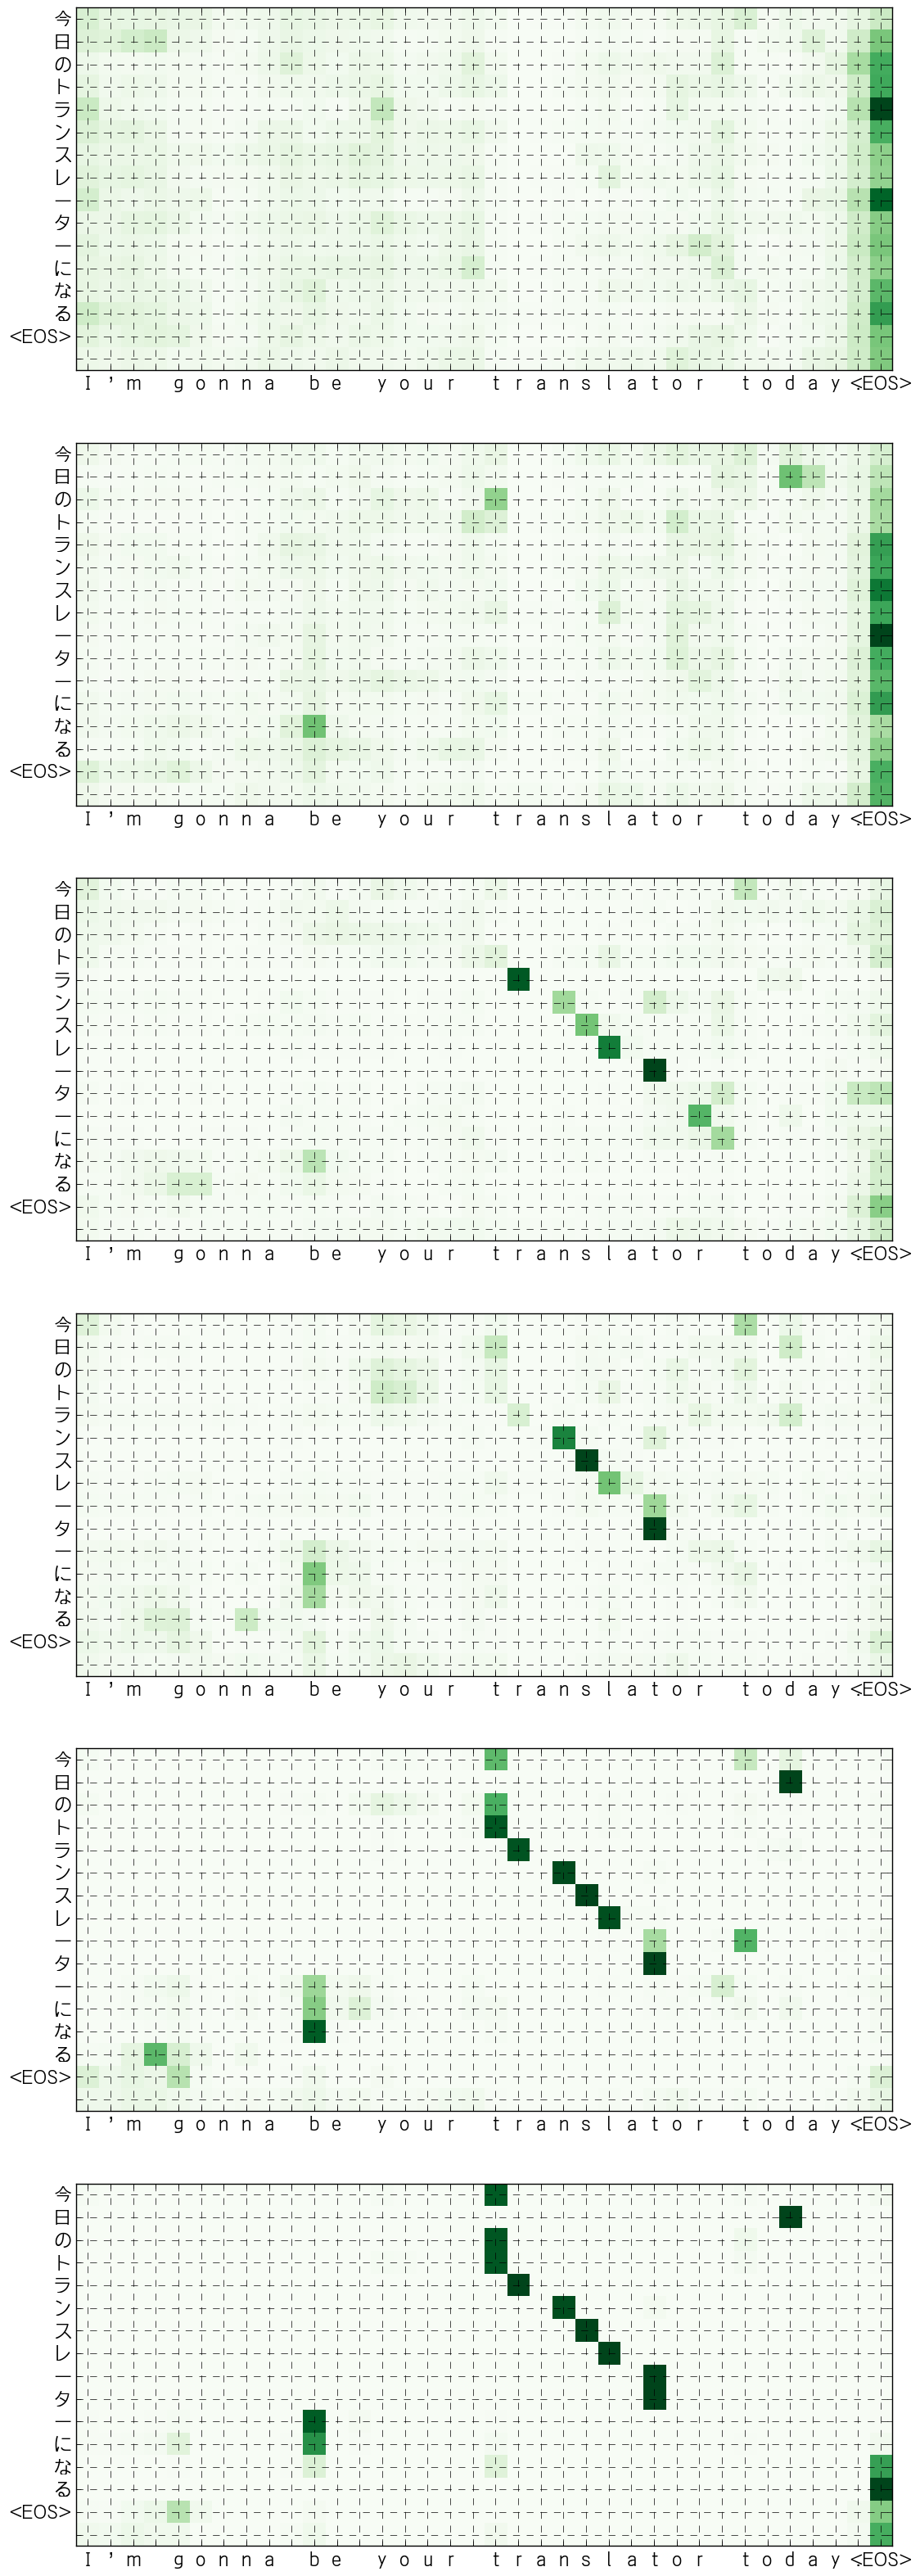

In [307]:
titles = ["I'm gonna be your translator today."]
kws = ["今日のトランスレーターになる"]

max_len = min(201, 1 + np.max([len(t) for t in titles]))
X_in = np.zeros((len(titles), max_len), dtype=np.int32)

max_len = min(22, 2 + np.max([len(t) for t in kws]))
Y_in = np.zeros((len(kws), max_len), dtype=np.int32)

for i, t in enumerate(titles):
    for j, x in enumerate(t):
        X_in[i, j] = en_dictionary.get(x, 2)
    X_in[i, j + 1] = 3

for i, t in enumerate(kws):
    for j, x in enumerate(t):
        Y_in[i, j + 1] = jp_dictionary.get(x, 2)
    Y_in[i, 0] = 1
    Y_in[i, j+2] = 3


attns = compute_attentions(isess, X_in, Y_in)

from matplotlib.font_manager import FontProperties
from matplotlib import rcParams

fp = FontProperties(fname='/home/jo/.fonts/fonts-horai-umefont-670/ume-hgo4.ttf', size=16)
rcParams['font.family'] = fp.get_name()

plt.gcf().set_size_inches(40, 40)
for i, a in enumerate(attns):
    plt.subplot(len(attns), 1, i + 1)
#     plt.title("attn %d" % i)
    plt.xticks(range(a[0].shape[1]), [en_inv_dictionary[i] for i in X_in[0]], size=16)
    plt.yticks(range(a[0].shape[0]), [jp_inv_dictionary[i] for i in Y_in[0][1:]], size=16)
    plt.imshow(a[0], interpolation="nearest", cmap=plt.cm.Greens) 
    plt.gca().grid(True, linestyle='--')
